In [1]:
# https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

import plotly.express as px

import sklearn.model_selection
import numpy as np

from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import QuantileTransformer, OneHotEncoder
from sklearn.model_selection import KFold
import sklearn.metrics


RANDOM_STATE = 42
DATASET_YEAR = 2010

In [2]:
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

In [3]:
target_column = 'SalePrice'


numerical_df = train_df.select_dtypes(include='number')

y=train_df[target_column]

numerical_df

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,62.0,7917,6,5,1999,2000,0.0,0,...,0,40,0,0,0,0,0,8,2007,175000
1456,1457,20,85.0,13175,6,6,1978,1988,119.0,790,...,349,0,0,0,0,0,0,2,2010,210000
1457,1458,70,66.0,9042,7,9,1941,2006,0.0,275,...,0,60,0,0,0,0,2500,5,2010,266500
1458,1459,20,68.0,9717,5,6,1950,1996,0.0,49,...,366,0,112,0,0,0,0,4,2010,142125


In [4]:
# Feature engineering - Encode non numerical columns
categorical_df = train_df.select_dtypes(exclude='number')
categorical_features = categorical_df.columns
categorical_df['Condition1'].value_counts()

Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: Condition1, dtype: int64

In [5]:
categorical_df

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1456,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,...,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1457,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,...,Attchd,RFn,TA,TA,Y,NaN,GdPrv,Shed,WD,Normal
1458,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [6]:
ohe_encoder = OneHotEncoder(handle_unknown='ignore')
ohe_encoder = ohe_encoder.fit(categorical_df)
ohe_encoder

OneHotEncoder(handle_unknown='ignore')

In [7]:
ohe_encoder.transform(categorical_df)

<1460x268 sparse matrix of type '<class 'numpy.float64'>'
	with 62780 stored elements in Compressed Sparse Row format>

In [8]:
ohe_df =pd.get_dummies(categorical_df, dummy_na=True)
ohe_df

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,MSZoning_nan,Street_Grvl,Street_Pave,Street_nan,Alley_Grvl,...,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
1,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
2,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
3,0,0,0,1,0,0,0,1,0,0,...,0,1,0,1,0,0,0,0,0,0
4,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
1456,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
1457,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
1458,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0


In [9]:
ohe_df[ohe_df['MSZoning_FV']==1]

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,MSZoning_nan,Street_Grvl,Street_Pave,Street_nan,Alley_Grvl,...,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
47,0,1,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
56,0,1,0,0,0,0,0,1,0,0,...,0,1,0,1,0,0,0,0,0,0
87,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
105,0,1,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
115,0,1,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1364,0,1,0,0,0,0,0,1,0,0,...,0,1,0,1,0,0,0,0,0,0
1365,0,1,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
1374,0,1,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
1442,0,1,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0


In [10]:
train_df[ohe_df['MSZoning_FV']==1]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
47,48,20,FV,84.0,11096,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2007,WD,Normal,249700
56,57,160,FV,24.0,2645,Pave,Pave,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2009,WD,Abnorml,172500
87,88,160,FV,40.0,3951,Pave,Pave,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2009,New,Partial,164500
105,106,60,FV,75.0,9375,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2008,WD,Normal,250000
115,116,160,FV,34.0,3230,Pave,Pave,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2007,WD,Normal,176000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1364,1365,160,FV,30.0,3180,Pave,Pave,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,144152
1365,1366,60,FV,NaN,7500,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2010,WD,Normal,216000
1374,1375,60,FV,85.0,10625,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,250000
1442,1443,60,FV,85.0,11003,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,310000


In [11]:
train_df =pd.concat([train_df, ohe_df], axis=1)
train_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,1,0,0,0,0,0,1,0,0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,1,0,0,0,0,0,1,0,0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,1,0,0,0,0,0,1,0,0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,1,0,1,0,0,0,0,0,0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,1,0,0,0,0,0,1,0,0
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,1,0,0,0,0,0,1,0,0
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,1,0,0,0,0,0,1,0,0
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,1,0,0,0,0,0,1,0,0


In [12]:
# Feature engineering - transform numerical columns (at least log transform on area features)
area_features =[col for col in train_df.columns if 'SF' in col and col != 'HouseStyle_SFoyer']
area_features

['BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'WoodDeckSF',
 'OpenPorchSF']

BsmtFinSF1


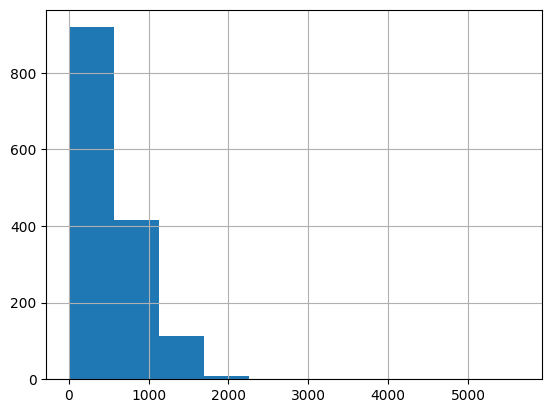

BsmtFinSF2


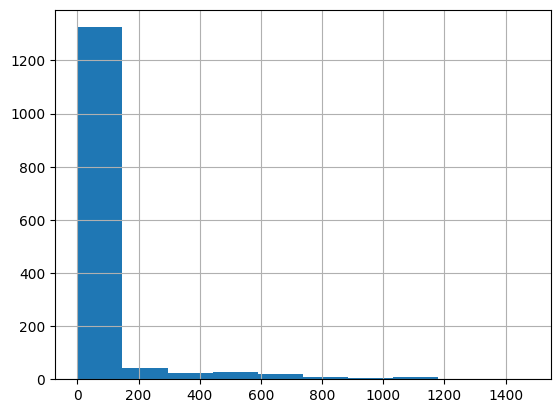

BsmtUnfSF


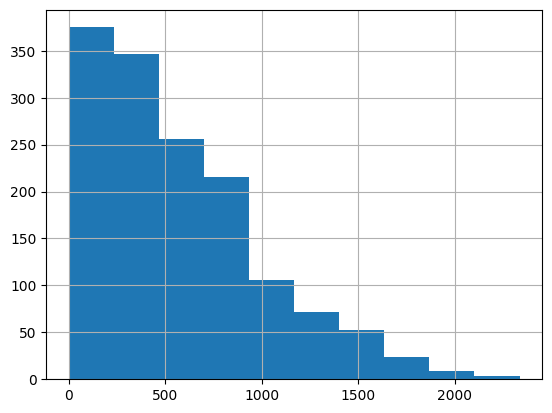

TotalBsmtSF


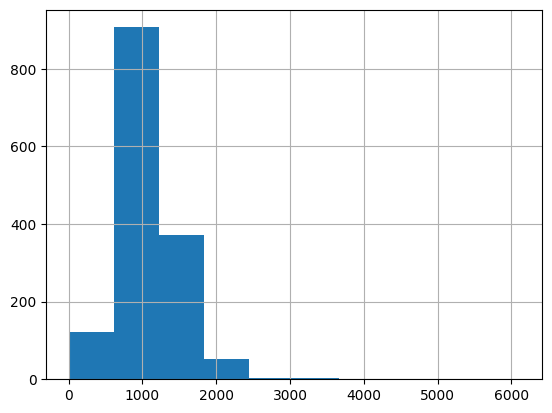

1stFlrSF


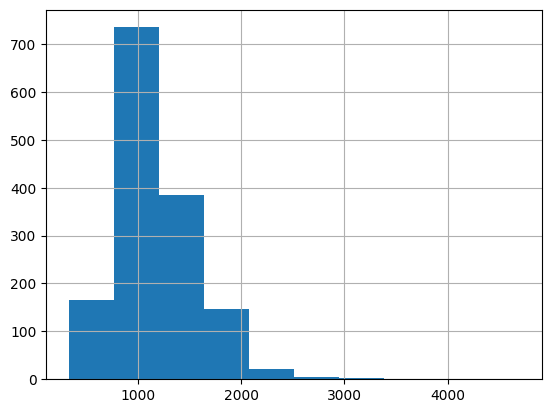

2ndFlrSF


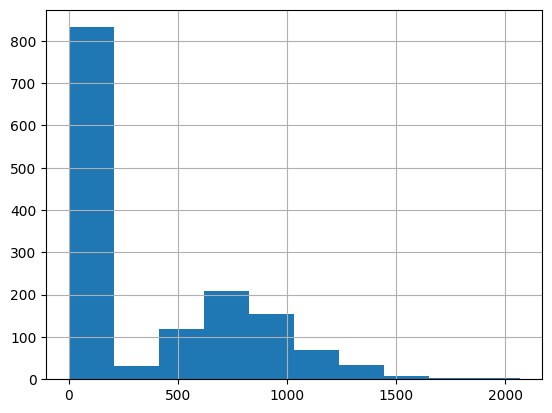

LowQualFinSF


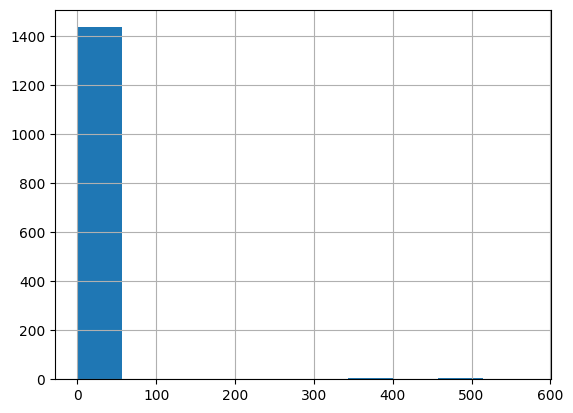

WoodDeckSF


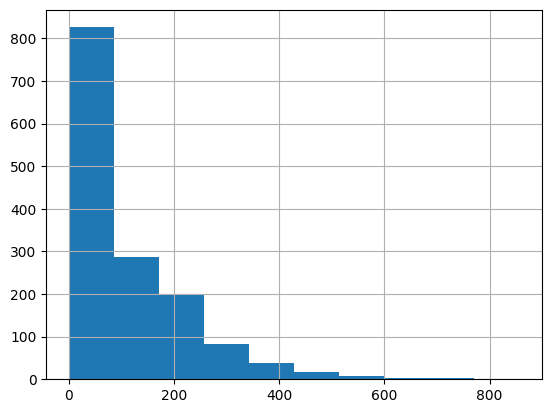

OpenPorchSF


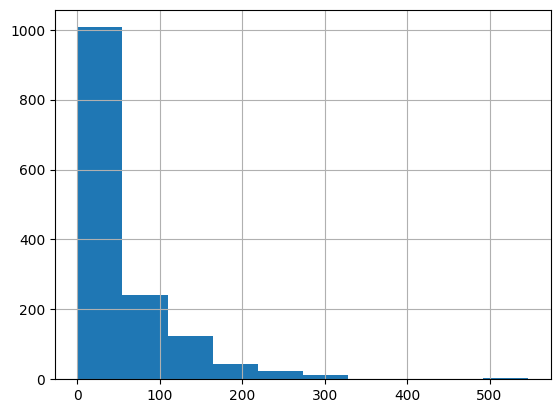

In [13]:
for feature in area_features:
  print(feature)
  train_df[feature].hist()
  plt.show()

In [14]:
(train_df[area_features]<0).sum(axis=0)

BsmtFinSF1      0
BsmtFinSF2      0
BsmtUnfSF       0
TotalBsmtSF     0
1stFlrSF        0
2ndFlrSF        0
LowQualFinSF    0
WoodDeckSF      0
OpenPorchSF     0
dtype: int64

BsmtFinSF1 log


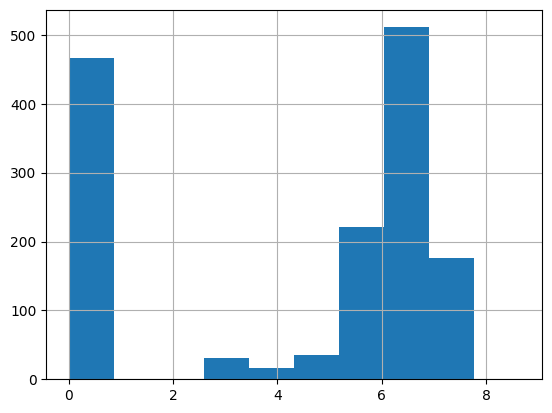

BsmtFinSF2 log


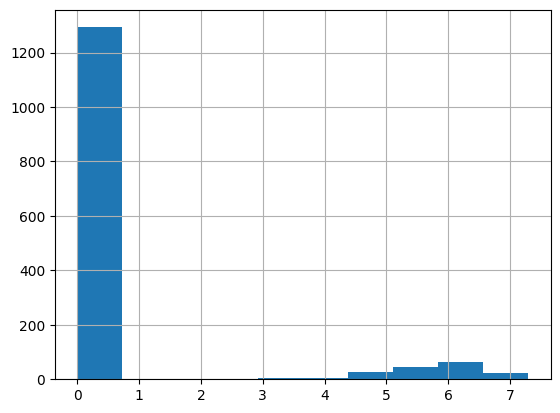

BsmtUnfSF log


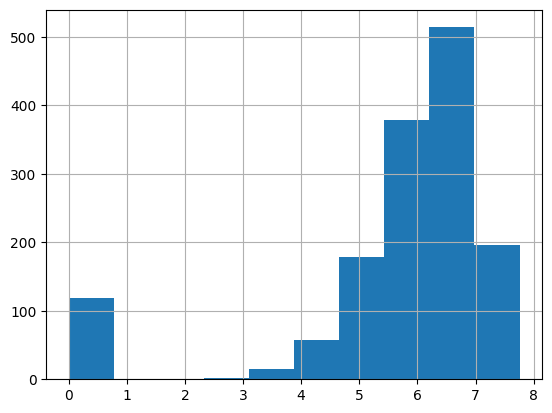

TotalBsmtSF log


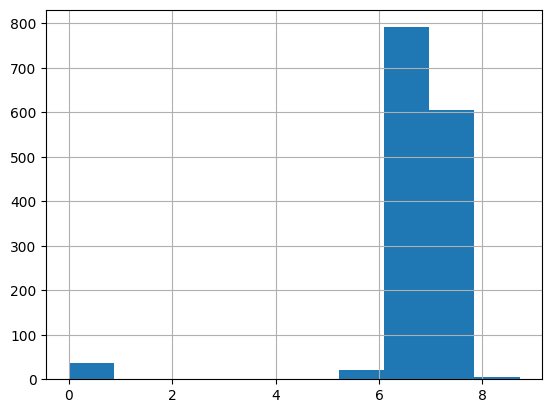

1stFlrSF log


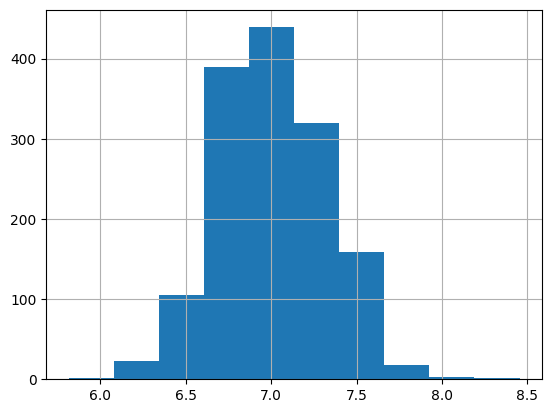

2ndFlrSF log


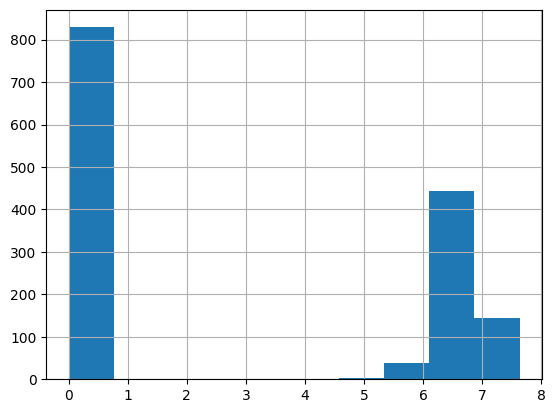

LowQualFinSF log


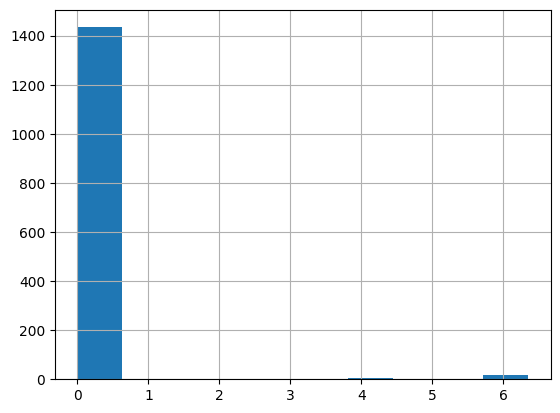

WoodDeckSF log


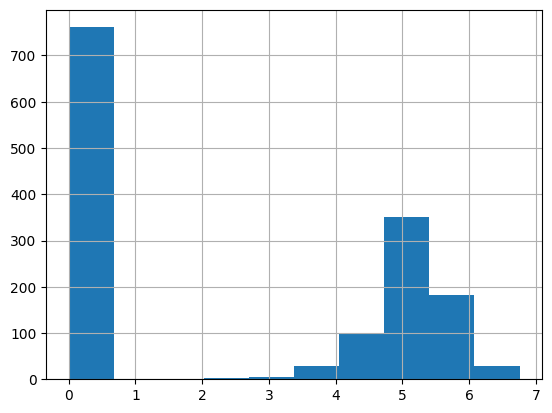

OpenPorchSF log


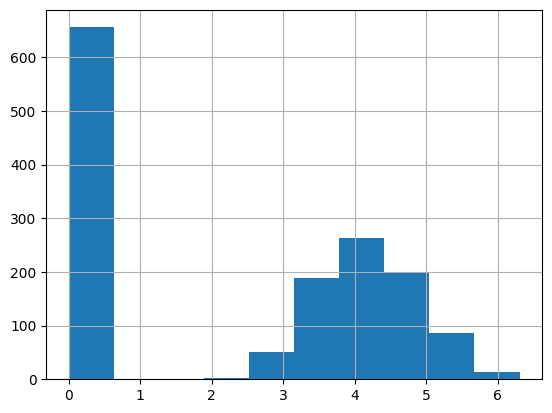

In [15]:
for feature in area_features:
  train_df[feature+'_log']=np.log(train_df[feature]+1)
  print(feature, 'log')
  train_df[feature+'_log'].hist()
  plt.show()

In [16]:
# Feature engineering - Create new feature (ex: years -> ages)
age_features = [col for col in train_df.columns if 'Yr' in col or 'Year' in col]
age_features

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']

In [17]:
train_df['sold_age']=train_df['YrSold']-train_df['YearBuilt']
train_df['remod_age']=train_df['YrSold']-train_df['YearRemodAdd']
train_df['garage_age']=train_df['YrSold']-train_df['GarageYrBlt']
train_df['transaction_age']=DATASET_YEAR - train_df['YrSold']

In [18]:
train_df.shape

(1460, 389)

In [19]:
features = train_df.drop(columns=list(categorical_features)+['Id', target_column]).columns
features

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       ...
       'TotalBsmtSF_log', '1stFlrSF_log', '2ndFlrSF_log', 'LowQualFinSF_log',
       'WoodDeckSF_log', 'OpenPorchSF_log', 'sold_age', 'remod_age',
       'garage_age', 'transaction_age'],
      dtype='object', length=344)

In [20]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor()

In [21]:
# Define a cross validation procedure
kf = KFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True)
kf

linear_model = LinearRegression()

for idx_train, idx_val in kf.split(train_df):
  X_train = train_df.loc[idx_train].drop(columns=['Id', target_column])[features]
  y_train = train_df[target_column][idx_train]
  X_val = train_df.loc[idx_val].drop(columns=['Id', target_column])[features]
  y_val = train_df[target_column][idx_val]
  xgb_model = xgb.XGBRegressor()
  xgb_model.fit(X=X_train, y=y_train)

  y_val_pred = xgb_model.predict(X=X_val)
  score = mean_squared_log_error(y_true=y_val, y_pred=y_val_pred)
  print(score)

0.021647166296736176
0.016847719119134973
0.027941061767360217
0.018376110812628216
0.014443193275221394


In [27]:

sklearn.model_selection.cross_val_score(estimator=xgb.XGBRegressor(),
                                        X=train_df[features],
                                        y=train_df[target_column],
                                        scoring=sklearn.metrics.make_scorer(mean_squared_log_error, greater_is_better=False)
                                        )


array([-0.01871219, -0.02384189, -0.02001041, -0.01779308, -0.01801704])

In [30]:
# Perform a grid search accross several models
grid_search =sklearn.model_selection.GridSearchCV(estimator = xgb.XGBRegressor(), param_grid={"subsample":[0.75, 1],
                "colsample_bytree":[0.75, 1],
                "max_depth":[2, 6],
                "min_child_weight":[1, 5],
                "learning_rate":[0.1, 0.01]},
                scoring=sklearn.metrics.make_scorer(mean_squared_log_error, greater_is_better=False))

grid_search.fit(X=train_df[features], y=train_df[target_column])

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bi...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.75, 1],
                         'learning_rate': [0.1, 0.01], 'max_depth': [2, 6],
                         'min_child_weight': [1, 5], 'subsample': [0.75, 1]},
             scoring=make_scorer(mean_squared_log_error, greater_is_better=False))

In [34]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_min_child_weight,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.553333,0.297110,0.042750,0.009823,0.75,0.1,2,1,0.75,"{'colsample_bytree': 0.75, 'learning_rate': 0....",-0.015334,-0.025446,-0.022043,-0.019275,-0.018495,-0.020119,0.003415,10
1,0.306448,0.011280,0.038114,0.001204,0.75,0.1,2,1,1,"{'colsample_bytree': 0.75, 'learning_rate': 0....",-0.015932,-0.025036,-0.022011,-0.019557,-0.019312,-0.020370,0.003031,12
2,0.816642,0.467529,0.077968,0.040009,0.75,0.1,2,5,0.75,"{'colsample_bytree': 0.75, 'learning_rate': 0....",-0.016349,-0.027176,-0.023460,-0.021065,-0.022714,-0.022153,0.003525,16
3,0.451459,0.285164,0.038425,0.000981,0.75,0.1,2,5,1,"{'colsample_bytree': 0.75, 'learning_rate': 0....",-0.016831,-0.025433,-0.022604,-0.019745,-0.021338,-0.021190,0.002868,13
4,0.736544,0.009396,0.038719,0.000431,0.75,0.1,6,1,0.75,"{'colsample_bytree': 0.75, 'learning_rate': 0....",-0.013950,-0.021174,-0.017828,-0.014961,-0.016929,-0.016968,0.002513,1
5,1.917322,1.659443,0.046021,0.007366,0.75,0.1,6,1,1,"{'colsample_bytree': 0.75, 'learning_rate': 0....",-0.013796,-0.022284,-0.018024,-0.015786,-0.016674,-0.017313,0.002840,2
6,0.559506,0.013158,0.039292,0.000961,0.75,0.1,6,5,0.75,"{'colsample_bytree': 0.75, 'learning_rate': 0....",-0.015102,-0.023350,-0.017934,-0.014780,-0.018866,-0.018006,0.003103,6
7,0.620526,0.015378,0.039954,0.001119,0.75,0.1,6,5,1,"{'colsample_bytree': 0.75, 'learning_rate': 0....",-0.014274,-0.021717,-0.017744,-0.015281,-0.018773,-0.017558,0.002637,4
8,0.733077,0.415345,0.061652,0.022260,0.75,0.01,2,1,0.75,"{'colsample_bytree': 0.75, 'learning_rate': 0....",-0.064062,-0.081852,-0.073004,-0.071442,-0.067397,-0.071551,0.006026,28
9,0.309050,0.007003,0.038784,0.001179,0.75,0.01,2,1,1,"{'colsample_bytree': 0.75, 'learning_rate': 0....",-0.064356,-0.081417,-0.073544,-0.072361,-0.068151,-0.071966,0.005735,32


In [36]:
grid_search.predict(train_df[features])

array([203723.36, 176833.55, 215915.1 , ..., 269820.88, 143388.75,
       147418.73], dtype=float32)

In [59]:

# Package your model in a pipeline
# https://medium.com/mlearning-ai/neat-data-preprocessing-with-pipeline-and-columntransformer-2a0468865b6b

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


reg_pipeline

Pipeline(steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  ['MSSubClass', 'LotFrontage',
                                                   'LotArea', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   '1stFlrSF', '2ndFlrSF',
                                                   'LowQualFinSF...
                                                   'LandContour', 'Utilities',
                                                   'LotConfig', 'LandSlope',
                                                   'Neighborhood', 'Condition1',
                                                   'Condition2', 'BldgType',
                                                   'HouseStyle', 'RoofStyle',
                                                   'RoofMatl', 'Exterior1st',
                                                   'Exterior2nd', 'MasVnrType',
                                                   'ExterQual', 'ExterCond',
                                                   'Foundation', 'BsmtQual',
                                                   'BsmtCond', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', ...])])),
                ('model', LinearRegression())])

In [62]:
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

numerical_df = train_df.select_dtypes(include='number')
categorical_df = train_df.select_dtypes(exclude='number')

num_cols = [col for col in numerical_df.columns if col not in ('Id', target_column)]
cat_cols = list(categorical_df.columns)

num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale',MinMaxScaler())
])

cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot',OneHotEncoder(handle_unknown='ignore', sparse=False))
])


col_trans = ColumnTransformer(transformers=[
    ('num_pipeline',num_pipeline,num_cols),
    ('cat_pipeline',cat_pipeline,cat_cols)
    ],
    remainder='drop',
    n_jobs=-1)

mlr= LinearRegression()

reg_pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', mlr)
])

def custom_msle(y_true, y_pred):
  y_pred = np.clip(y_pred, 0, None)
  return mean_squared_log_error(y_true=y_true, y_pred=y_pred)

sklearn.model_selection.cross_val_score(estimator=reg_pipeline,
                                        X=train_df.drop(columns=['Id', target_column]),
                                        y=train_df[target_column],
                                        scoring=sklearn.metrics.make_scorer(custom_msle, greater_is_better=False)
                                        )

array([ -5.27447877,  -9.55700259,  -6.98417249,  -3.41131569,
       -11.2382591 ])

In [67]:
# Very bad scores due to dimensionality curse and lack of proper feature engineering

34900

In [50]:
train_df.drop(columns=['Id', target_column])

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
1456,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal
1457,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal
1458,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal


In [63]:
reg_pipeline.fit(X=train_df.drop(columns=['Id', target_column]), y=train_df[target_column])

Pipeline(steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  ['MSSubClass', 'LotFrontage',
                                                   'LotArea', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   '1stFlrSF', '2ndFlrSF',
                                                   'LowQualFinSF...
                                                   'LandContour', 'Utilities',
                                                   'LotConfig', 'LandSlope',
                                                   'Neighborhood', 'Condition1',
                                                   'Condition2', 'BldgType',
                                                   'HouseStyle', 'RoofStyle',
                                                   'RoofMatl', 'Exterior1st',
                                                   'Exterior2nd', 'MasVnrType',
                                                   'ExterQual', 'ExterCond',
                                                   'Foundation', 'BsmtQual',
                                                   'BsmtCond', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', ...])])),
                ('model', LinearRegression())])

In [65]:
y_hat_test =reg_pipeline.predict(X=test_df.drop(columns=['Id']))

In [66]:
submission_df = pd.DataFrame({'Id': test_df['Id'], target_column: y_hat_test})
submission_df.to_csv('/content/submission_pipeline.csv', index=False)